# Let's Train Tiny MoE





### Configure the machine and install packages


In [1]:
from typing import Literal

import os

os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax

platform : Literal["darwin", "colab", "cuda", "tpu"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"
    if any(d.platform == "tpu" for d in devices):
        platform = "tpu"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken datasets --quiet
    !pip uninstall -y tensorflow

Running on darwin


In [2]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )


sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/Users/vikram/dev/jaxpt/src


In [3]:
import os


import warnings

import jax
from jax.sharding import Mesh, PartitionSpec, NamedSharding
import flax
import jax.numpy as jnp
import numpy as np

# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)

devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Set up device mesh


mesh = jax.sharding.Mesh(jax.devices(), ["devices"])

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Make sure matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Flax version 0.10.4
Available devices: 8


/var/folders/x4/85_9sn3d1ng9q48ff6t3fw340000gn/T/ipykernel_54732/3250393803.py:26: UserWarning: not using gpu. Using cpu
  warnings.warn(f"not using {requested_device}. Using {device}")


217 ms ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialize the model and perform a sanity check

In [4]:
from datetime import datetime
import random
import string

from jaxpt.checkpointers import save_checkpoint, load_checkpoint, load_checkpoint_from_gcloud

def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()

run_dirname = f"run_{timestamp}_{random_code}"
print(f"Run: {run_dirname}")

if platform == "cuda":
  output_dir = Path("/home/ubuntu/alpha_training_runs") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent  / "alpha_training_runs" # Local setup

Run: run_20250717_ppqsmn


In [5]:
from flax import nnx

from jaxpt.infer import generate_completions, generate
from jaxpt.models import Tiny_MoE_Config, Tiny_MoE
from jaxpt.utils import count_params, create_sharded_model

import tiktoken
from transformers import AutoTokenizer

key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = Tiny_MoE_Config(dtype=jnp.bfloat16, \
                     #vocab_size=49152,
                     n_layer=4,
                     block_size=1024,
                     n_head=4,
                     n_kv_head=2,
                     n_embed=128,
                     n_mlp_hidden=384,
                     sdpa_implementation="cudnn" if device=="gpu" else "xla")
nnx.display(config)

with mesh:
    m = create_sharded_model(Tiny_MoE, config, rngs)
    #m = load_checkpoint(Tiny_MoE, output_dir, config, "run_20250716_htlpzj", 180000, rngs)
    #m = load_checkpoint_from_gcloud(Mobile_LLM, config, output_dir, "alpha_training_runs", "run_20250521_pakugd", "9000", rngs)
    #m = from_hf_pretrained(config, rngs)

    graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
    total_params = count_params(m)
    moe_params = count_params(m, "moe")

    print(f"Parameter Count: {total_params:,}")
    print(f"MOE Parameter Count: {moe_params:,}")
    print(f"Replicated Parameter Count: {total_params - moe_params:,}")
    nnx.display(state)

    #tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
    enc = tiktoken.get_encoding("gpt2")
    m.eval(add_noise=False, aux_loss=False)
    completions = generate_completions(m, enc=enc, num_completions=8,
                                    max_length=21,
                                    prefix="Ducks quack, donkeys bray, cats mew, horses")
    for completion in completions:
        print(completion)

Parameter Count: 9,307,264
MOE Parameter Count: 2,375,680
Replicated Parameter Count: 6,931,584


Ducks quack, donkeys bray, cats mew, horses horses horses horses horses horses horses
Ducks quack, donkeys bray, cats mew, horses horses horses horses horses horses horses
Ducks quack, donkeys bray, cats mew, horses horses horses horses horses horses horses
Ducks quack, donkeys bray, cats mew, horses horses horses horses horses horses horses
Ducks quack, donkeys bray, cats mew, horses horses horses horses horses horses horses
Ducks quack, donkeys bray, cats mew, horses horses horses horses horses horses horses
Ducks quack, donkeys bray, cats mew, horses horses horses horses horses horses horses
Ducks quack, donkeys bray, cats mew, horses horses horses horses horses horses horses


### Configure Training Run

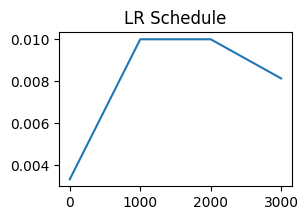

tokens/batch: 4,096
block size: 128
batch size: 32
no. gradient accumulation steps: 1
effective batch size: 32
effective batch size per device:  4
max steps: 3,583


In [53]:
import dataclasses

import optax


############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens_per_batch: int = 2**12 # 2**19, 0.5 million as per the GPT 3.5 paper
  mB: int = 4 * num_devices
  T: int = 128
  max_steps: int = int((146776*100) // (2**12))
  max_lr: float = 1e-2
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 3
  print_interval: int = 5 
  eval_interval: int = 5000
  checkpoint_interval: int = 10000
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=2**4,
  T=2**5,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)

trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient
'''

# Set up the optimizer
def trapezoidal_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    cooldown_lr = trconf.max_lr * (trconf.max_steps - step) / (trconf.max_steps - 0.8 * trconf.max_steps)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < 0.8 * trconf.max_steps, trconf.max_lr, cooldown_lr))

steps = range(0, trconf.max_steps, 1000)
total_schedule = [ trapezoidal_schedule(step) for step in steps ]
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(steps, total_schedule)
plt.title("LR Schedule")
plt.show()

tx = optax.chain(
    #optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adafactor(trapezoidal_schedule)
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 20

print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB // num_devices)
print(f"max steps: {trconf.max_steps:,}")


### DataLoader and Validation Setup



In [54]:
import os

from jaxpt.dataloaders import DataLoader, HuggingfaceDataLoader, CloudDataLoader

'''
train_dl = HuggingfaceDataLoader(batch_size=trconf.mB,
                                 block_size=trconf.T,
                                 device_rank=1,
                                 tokenizer="HuggingFaceTB/SmolLM-135M",
                                 dataset_paths=["HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus"],
                                 dataset_names=["cosmopedia-v2",
                                                "python-edu",
                                                "fineweb-edu-dedup"],
                                 probabilities=[0.111, 0.016 , 0.873],
                                 label="train",
                                 random_seed=1337,
                                 buffer_size=10_000,
                                 streaming=True)
'''

#os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../alpha-448101-282bc1b884cd.json"

#train_dl = CloudDataLoader(bucket_name="jaxpt_datasets",
#                      bucket_prefix="fineweb-edu-100b/processed",
#                      batch_size=trconf.mB,
#                      block_size=trconf.T,
#                      device_rank=1,
#                      label="train")

train_dl = DataLoader(dirpath="/Users/vikram/dev/jaxpt/datasets/panchatantra-ryder/processed",
                      batch_size=trconf.mB,
                      block_size=trconf.T,
                      device_rank=1,
                      label="train")



DataLoader initialized:
------------------------
label:          train
shards:         1
shard size:     146,776
batch size:     32
block size:     128
device rank:    1
------------------------


In [55]:
from jaxpt.utils import append_to_csv

# Create log dir
log_dir = output_dir / m.config.name / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

train_losses = []
append_to_csv(log_dir / f"{run_dirname}_train.csv", ["step", "lr", "loss", "time", "tokens_processed", "tokens_per_sec"])
step = 0

Log directory: /Users/vikram/dev/jaxpt/alpha_training_runs/Tiny_MoE/logs


Received KeyboardInterrupt. Exiting...: 1407.53ms | tokens processed: 2,113,536 | tok/sec: 2,910.06


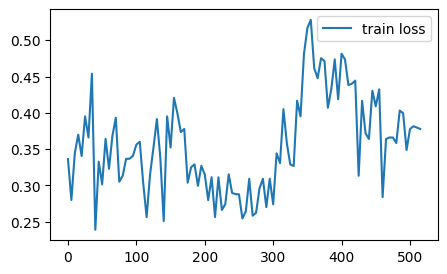

In [58]:
%matplotlib inline

import time

import matplotlib.pyplot as plt

from jaxpt.train import moe_loss_fn

@nnx.jit
def train_step(model, optimizer, batch, target):
    batch = batch.squeeze()
    target = target.squeeze()
    loss, grads = nnx.value_and_grad(moe_loss_fn)(model, batch, target)
    optimizer.update(grads)
    return loss


with mesh:
  data_sharding = NamedSharding(mesh, PartitionSpec("devices",))
  m.train(add_noise=True, aux_loss=True)
  try:
    while step < trconf.max_steps:
      start = time.time()
      batch, target = train_dl()
      batch = jax.device_put(batch.squeeze(), data_sharding)
      target = jax.device_put(target.squeeze(), data_sharding)
      avg_loss = train_step(m, optimizer, batch, target)
      avg_loss.block_until_ready()
      iter_time = time.time() - start
      if step % trconf.print_interval == 0:
        avg_loss = avg_loss.item()
        lr = trapezoidal_schedule(step)
        sub_step_time = iter_time / trconf.grad_accumulation_steps
        tokens_per_sec = trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
        tokens_processed = (step+1) * trconf.grad_accumulation_steps * trconf.mB * trconf.T

        train_losses.append((step, avg_loss))
        append_to_csv(log_dir / f"{run_dirname}_train.csv", [step, lr, avg_loss, iter_time*1000, tokens_processed, tokens_per_sec])
        print(f"{step} | lr: {lr:0.4f} | "
              f"loss: {avg_loss:0.4f} | "
              f"time: {iter_time*1000:0.2f}ms | "
              f"tokens processed: {tokens_processed:,} | "
              f"tok/sec: {tokens_per_sec:,.2f}", end="\r")
      if step % trconf.eval_interval == 0:
        print("Evaluation TBD")
        #save_checkpoint(m, output_dir, run_dirname, step)
      step += 1

  except KeyboardInterrupt:
      print("Received KeyboardInterrupt. Exiting...")

  plt.figure(figsize=(5, 3))
  plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
  plt.legend()
  plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
  plt.show()


In [ ]:
save_checkpoint(m, output_dir, run_dirname, step)

In [44]:
with mesh:
    m.eval(add_noise=False, aux_loss=False)
    enc = tiktoken.get_encoding("gpt2")
    completions = generate_completions(m, enc=enc, num_completions=8,
                                    max_length=21,
                                    prefix="Once upon a time")
    for completion in completions:
        print(completion)

Once upon a time time time time time time time time time time time time time time time time time time
Once upon a time time time time time time time time time time time time time time time time time time
Once upon a time time time time time time time time time time time time time time time time time time
Once upon a time time time time time time time time time time time time time time time time time time
Once upon a time time time time time time time time time time time time time time time time time time
Once upon a time time time time time time time time time time time time time time time time time time
Once upon a time time time time time time time time time time time time time time time time time time
Once upon a time time time time time time time time time time time time time time time time time time
